In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import random


from numpy import random
from sklearn.preprocessing import OrdinalEncoder
from IPython import display


#tf.compat.v1.disable_eager_execution()

#%matplotlib inline
random.seed(246)

In [2]:
from Preparation import *
df_train, df_test, df_valid = prep_data()

In [3]:
df = pd.concat([df_train, df_valid, df_test], ignore_index=True)

In [4]:
split_train_ratio = 0.8
num_epochs = 30
lr = 0.001
batch_size = 30
max_journ_len = 16 #as specified in prep_data.jpynb
layer1size = 32
layer2size = 32

In [5]:
journeys = df['journey_id'].unique()

In [6]:
split_ratios = [split_train_ratio, 1-split_train_ratio]
split_data = random_split(journeys, split_ratios)

In [7]:
df_train = df[df['journey_id'].isin(split_data[0])]
df_test = df[df['journey_id'].isin(split_data[1])]

# Next step: transform to tensor

In [8]:
# mta2

In [9]:
X_test, Y_test = mta2tensor(df_train, max_journ_len)
X_train, Y_train = mta2tensor(df_test, max_journ_len)


In [10]:
#tf.convert_to_tensor(X_test)

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.batch(batch_size)

In [12]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_dataset = test_dataset.batch(batch_size)

In [13]:
time_steps = max_journ_len
input_dim = df_train.shape[1] - 2  # -2 weil journey_id und transaction wegfällt
num_classes = 2

In [14]:
import keras

In [15]:
modelGRU = keras.Sequential()

modelGRU.add(
    tf.keras.layers.RNN(
         tf.keras.layers.GRUCell(units = layer1size, input_shape=(time_steps, input_dim)),
        return_sequences=True,
        return_state=False,
        go_backwards=False,
        stateful=False,
        unroll=False,
        time_major=False
    )
)
modelGRU.add(
    tf.keras.layers.RNN(
        tf.keras.layers.GRUCell(units = layer2size),
        return_sequences=False,
        return_state=False,
        go_backwards=False,
        stateful=False,
        unroll=False,
        time_major=False
    )
)

modelGRU.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [16]:
class LossHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        self.train_losses = []
        self.test_losses = []

    def on_epoch_end(self, epoch, logs=None):
        self.train_losses.append(logs.get('loss'))
        self.test_losses.append(logs.get('val_loss'))

In [17]:
modelGRU.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='sparse_categorical_crossentropy')

# Create instances of the custom callback
loss_history_GRU = LossHistory()

# Train the model with the custom callback

modelGRU.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset, callbacks=[loss_history_GRU])

Epoch 1/30
12/12 [==============================] - 5s 86ms/step - loss: 0.6844 - val_loss: 0.6470
Epoch 2/30
12/12 [==============================] - 0s 39ms/step - loss: 0.6165 - val_loss: 0.6130
Epoch 3/30
12/12 [==============================] - 0s 39ms/step - loss: 0.5926 - val_loss: 0.5890
Epoch 4/30
12/12 [==============================] - 0s 39ms/step - loss: 0.5752 - val_loss: 0.5689
Epoch 5/30
12/12 [==============================] - 0s 36ms/step - loss: 0.5578 - val_loss: 0.5546
Epoch 6/30
12/12 [==============================] - 0s 39ms/step - loss: 0.5439 - val_loss: 0.5449
Epoch 7/30
12/12 [==============================] - 0s 38ms/step - loss: 0.5345 - val_loss: 0.5374
Epoch 8/30
12/12 [==============================] - 0s 39ms/step - loss: 0.5285 - val_loss: 0.5312
Epoch 9/30
12/12 [==============================] - 0s 37ms/step - loss: 0.5242 - val_loss: 0.5261
Epoch 10/30
12/12 [==============================] - 0s 37ms/step - loss: 0.5206 - val_loss: 0.5219
Epoch 11/

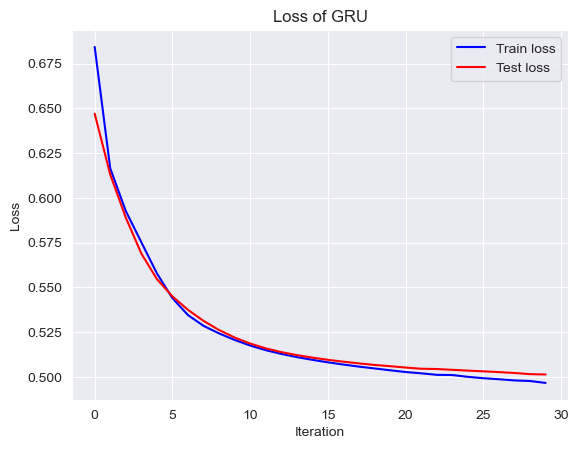

In [18]:
plt.plot(loss_history_GRU.train_losses, '-b', label='Train loss')
plt.plot(loss_history_GRU.test_losses, '-r', label='Test loss')
plt.legend(loc=0)
plt.title('Loss of GRU')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

# DIY GRU

In [19]:
from Keras_GRU import *

In [20]:
modelphasedGRU = keras.Sequential()

modelphasedGRU.add(
    tf.keras.layers.RNN(
        phased_GRUCell(units = layer1size, input_shape=(time_steps, input_dim), time_gate=True),
        return_sequences=True,
        return_state=False,
        go_backwards=False,
        stateful=False,
        unroll=False,
        time_major=False
    )
)
modelphasedGRU.add(
    tf.keras.layers.RNN(
        phased_GRUCell( units = layer2size),
        return_sequences=False,
        return_state=False,
        go_backwards=False,
        stateful=False,
        unroll=False,
        time_major=False
    )
)

modelphasedGRU.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [21]:
modelphasedGRU.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='sparse_categorical_crossentropy')

# Create instances of the custom callback
loss_history_phasedGRU = LossHistory()

# Train the model with the custom callback

modelphasedGRU.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset, callbacks=[loss_history_phasedGRU])

Epoch 1/30
Tensor("rnn_2/phased_gru_cell/strided_slice:0", shape=(None, 117), dtype=float32)
Tensor("rnn_2/while/phased_gru_cell/strided_slice:0", shape=(None, 117), dtype=float32)
Tensor("rnn_3/phased_gru_cell_1/strided_slice:0", shape=(None, 31), dtype=float32)
Tensor("rnn_3/while/phased_gru_cell_1/strided_slice:0", shape=(None, 31), dtype=float32)
Tensor("sequential_1/rnn_2/phased_gru_cell/strided_slice:0", shape=(None, 117), dtype=float32)
Tensor("sequential_1/rnn_2/while/phased_gru_cell/strided_slice:0", shape=(None, 117), dtype=float32)
Tensor("sequential_1/rnn_3/phased_gru_cell_1/strided_slice:0", shape=(None, 31), dtype=float32)
Tensor("sequential_1/rnn_3/while/phased_gru_cell_1/strided_slice:0", shape=(None, 31), dtype=float32)
Tensor("sequential_1/rnn_2/phased_gru_cell/strided_slice:0", shape=(None, 117), dtype=float32)
Tensor("sequential_1/rnn_2/while/phased_gru_cell/strided_slice:0", shape=(None, 117), dtype=float32)
Tensor("sequential_1/rnn_3/phased_gru_cell_1/strided_slic

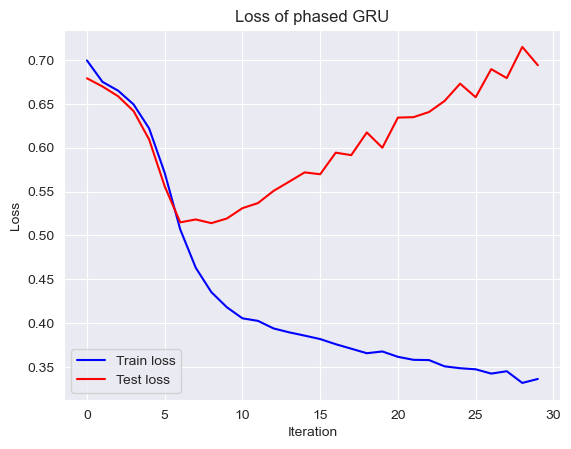

In [22]:
plt.plot(loss_history_phasedGRU.train_losses, '-b', label='Train loss')
plt.plot(loss_history_phasedGRU.test_losses, '-r', label='Test loss')
plt.legend(loc=0)
plt.title('Loss of phased GRU')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

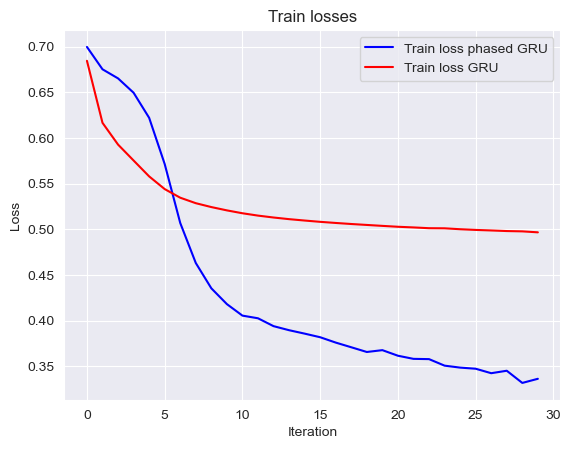

In [23]:
plt.plot(loss_history_phasedGRU.train_losses, '-b', label='Train loss phased GRU')
plt.plot(loss_history_GRU.train_losses, '-r', label='Train loss GRU')
plt.legend(loc=0)
plt.title('Train losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

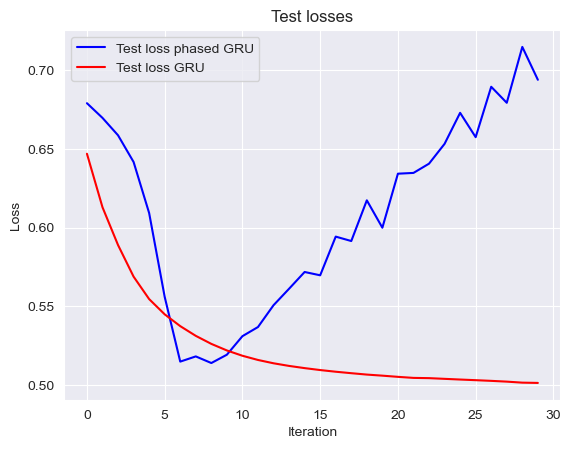

In [24]:
plt.plot(loss_history_phasedGRU.test_losses, '-b', label='Test loss phased GRU')
plt.plot(loss_history_GRU.test_losses, '-r', label='Test loss GRU')
plt.legend(loc=0)
plt.title('Test losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [25]:
modelGRU.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn (RNN)                   (None, 16, 32)            14592     
                                                                 
 rnn_1 (RNN)                 (None, 32)                6336      
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 20,994
Trainable params: 20,994
Non-trainable params: 0
_________________________________________________________________


In [26]:
modelphasedGRU.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn_2 (RNN)                 (None, 16, 32)            14566     
                                                                 
 rnn_3 (RNN)                 (None, 32)                6310      
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 20,942
Trainable params: 20,942
Non-trainable params: 0
_________________________________________________________________


# Explanations


In [27]:
modelGRU.evaluate(test_dataset)

46/46 [==============================] - 0s 9ms/step - loss: 0.5013


0.5013056993484497

In [28]:
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [29]:
X_train = tf.convert_to_tensor(X_train)

In [30]:
X_test = tf.convert_to_tensor(X_test)

In [31]:
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 16, 118), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [32]:
X_train

<tf.Tensor: shape=(340, 16, 118), dtype=float32, numpy=
array([[[1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 6.3034893e+03],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 3.6356382e+03],
        [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 3.6355847e+03],
        [0.000000

In [33]:
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
e = shap.DeepExplainer(modelGRU, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(X_test[1:5])

# plot the feature attributions
shap.image_plot(shap_values, -X_test[1:5])

TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got array([ 49, 141,  91, 252, 155,  33,  11, 237, 287,  59, 286, 173, 103,
       321, 282, 151,   5, 191, 179, 295, 333,   2, 268, 246, 314,  61,
        63,  53,  28, 201, 325, 331, 253, 150, 152, 234, 126,  68,  82,
        27, 185, 327, 219,  75, 190, 202, 131, 307, 272, 297,  18,  16,
       267, 270, 122, 258, 196, 336, 249,  14,  90,  51, 156,  69, 332,
         0,  23, 120, 204, 119, 139, 207, 229, 323, 144, 182,  54, 104,
        98, 279, 275, 291, 132, 200, 176,  40,  87, 147, 110, 320,  88,
       211, 142, 309, 114, 274, 221,  52, 232, 127])

In [ ]:

from keras.datasets import imdb

# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(modelGRU, X_train[:100])

# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(X_test[:10])

# init the JS visualization code
shap.initjs()

In [ ]:

# transform the indexes to words
import numpy as np


# plot the explanation of the first prediction
# Note the model is "multi-output" because it is rank-2 but only has one column
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_test[0])